I wanted to:
- Validate that my derivations and implementations were correct
- Get a better feel for how much the different components mattered
- Get a better feel for in which situations this would matter more

Process:
- I created a way to generate the data from n pixels assuming total spatial independence - so this simulation does not allow us to assess bootstrap approaches, just the survival approaches. This returns the 4 different data types, dts, cts, uts, rts (picture added below for reference)
- Data is actually in time, count splits with times rounded, this is to validate the performance improvement approach is valid
- I then ran this 1000 times, and for each of them I fit the data using different combinations of the data
- I then report the fitted parameters and fire return interval, as well as their 10th and 90th percentiles

Names of fits done:
- Dt only: I only used the dts
- Dtct: dts and cts (This is the survival model I have used until now)
- Dtctut: dts + cts +uts 
- Dtctutet:dts+cts+uts+ #empty pixels (This is the full model that I intend to use)

I then repeated this whole process for different true parameters and number of pixels

Finally as I was occasionally getting fitting errors during this process, I added a column to see if different data subsets were causing this to happen more/less often.

(np.float64(-0.5), np.float64(760.5), np.float64(414.5), np.float64(-0.5))

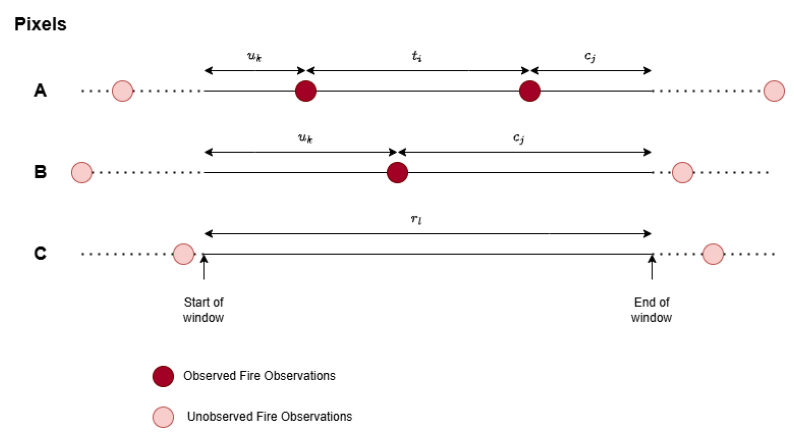

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load the image
img = mpimg.imread(
    "mtbs_fire_analysis/analysis/statistical_tests/Fire interval censoring diagram.png"
)
# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")  # Hide axes

In [2]:
import pandas as pd
from IPython.display import display

from mtbs_fire_analysis.analysis.hlh_dist import (
    HalfLifeHazardDistribution as HLHD,
)
from mtbs_fire_analysis.analysis.statistical_tests.all_sensors_repeat import (
    run_hlh_simulation,
)

pd.set_option("display.precision", 2)

In [3]:
def plot_hlh_params(fit_out):
    plot_data = pd.DataFrame(
        fit_out, columns=["hazard_inf", "half_life", "fri"]
    )
    plt.figure(figsize=(10, 6))
    plt.scatter(
        plot_data["hazard_inf"],
        plot_data["half_life"],
        alpha=0.5,
        label="dtctutet",
    )
    plt.xlabel("Hazard_Inf")
    plt.ylabel("Half Life")
    plt.title("HLHD Fit Results")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

### Experiment 1
If we have a fire return interval (fri) that is low, all of the approaches should do well.

In [4]:
out_df1, fit_outs1 = run_hlh_simulation(
    num_pixels=500,
    time_interval=39,
    iterations=1000,
    truth=HLHD(hazard_inf=0.25, half_life=2),
    pre_window=1000,
    random_seed=42,
)

/workspaces/mtbs_fire_analysis/mtbs_fire_analysis/analysis/hlh_dist.py:85: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(t))
/workspaces/mtbs_fire_analysis/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [5]:
display(out_df1)

,name,hazard_inf_10pc,hazard_inf_mean,hazard_inf_90pc,half_life_10pc,half_life_mean,half_life_90pc,mean_10pc,mean_mean,mean_90pc,fail_prob
0,truth,0.25,0.25,0.25,2.00,2.00,2.00,6.22,6.22,6.22,0.00
1,dt_only,0.28,0.29,0.31,1.85,2.05,2.27,5.53,5.62,5.71,0.29
2,dtct,0.24,0.25,0.26,1.82,2.02,2.23,6.12,6.22,6.33,0.29
3,dtctut,0.24,0.25,0.26,1.83,2.02,2.22,6.12,6.22,6.32,0.29
4,dtctutet,0.24,0.25,0.26,1.82,2.02,2.22,6.12,6.22,6.32,0.29
5,naive,0.00,0.00,0.00,0.00,0.00,0.00,6.11,6.22,6.33,0.00


In this case even though the true fire return interval is 6.2 years vs the observation window of 38 years, dts alone cannot recover this accurately, though it's not too bad (5.6 vs 6.2). We get a large number of failed fits (29%) I don't know why, there must be some unstable behavior in my process. It doesn't appear to be imparting a bias though. 
Once we add the cts to the process we recover everything with tight confidence intervals, uts and ets and almost nothing (unsurprising given there should be almost no pixels with no events at this point).

### Experiment 2
A more middling fire return interval, still well under the observation window

In [11]:
out_df2, fit_outs2 = run_hlh_simulation(
    num_pixels=500,
    time_interval=39,
    iterations=1000,
    truth=HLHD(hazard_inf=0.15, half_life=10),
    pre_window=1000,
    random_seed=42,
)

/workspaces/mtbs_fire_analysis/mtbs_fire_analysis/analysis/hlh_dist.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(t))
/workspaces/mtbs_fire_analysis/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [12]:
display(out_df2)

,name,hazard_inf_10pc,hazard_inf_mean,hazard_inf_90pc,half_life_10pc,half_life_mean,half_life_90pc,fri_10pc,fri_mean,fri_90pc,fail_count
0,truth,0.150000,0.150000,0.150000,10.000000,10.000000,10.000000,15.079163,15.079163,15.079163,0
1,dt_only,0.249875,0.341976,0.450475,11.124028,16.935284,23.957004,11.384062,11.676784,11.971415,12
2,dtct,0.127458,0.155468,0.190857,7.745937,10.528327,13.862509,14.675406,15.093967,15.523713,12
3,dtctut,0.150919,0.177564,0.208393,9.780963,12.617618,15.722709,14.615564,14.953616,15.279909,12
4,dtctutet,0.133382,0.152864,0.174596,8.225125,10.302222,12.475542,14.753175,15.088977,15.423996,12
5,naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.739229,15.085539,15.427215,0


Here we can see that both dts+cts and the full model both do well, with the full model perhaps having tighter confidence in the fri, and noticably better confidence in the params. Fail counts are now around 1% for all approaches, unclear why the first experiment had so much higher change to fail a fit.


### Experiment 3
Domains with fire return intervals ~=observation window

In [5]:
out_df3, fit_outs3 = run_hlh_simulation(
    num_pixels=500,
    time_interval=39,
    iterations=1000,
    truth=HLHD(hazard_inf=0.05, half_life=20),
    pre_window=1000,
    random_seed=42,
)

/workspaces/mtbs_fire_analysis/mtbs_fire_analysis/analysis/hlh_dist.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(t))
/workspaces/mtbs_fire_analysis/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [6]:
display(out_df3)

,name,hazard_inf_10pc,hazard_inf_mean,hazard_inf_90pc,half_life_10pc,half_life_mean,half_life_90pc,fri_10pc,fri_mean,fri_90pc,fail_count
0,truth,0.050000,0.050000,0.050000,20.000000,20.000000,20.000000,38.913564,38.913564,38.913564,0
1,dt_only,7.244872,9.253616,10.000000,908.968404,1118.575278,1318.067285,15.660101,16.533723,17.348974,13
2,dtct,0.030758,0.730946,0.325972,9.973460,383.645190,162.291050,34.578118,39.399088,45.255049,5
3,dtctut,3.858711,8.228810,10.000000,1455.299359,3094.786907,3937.724716,28.420936,29.234241,30.062895,55
4,dtctutet,0.041434,0.056060,0.068047,14.092025,24.338448,32.215317,37.279786,38.964390,40.601069,2
5,naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.284895,38.962388,40.625000,0


Here the differences become stark. The full model has a ~3x tighter confidence interval than the dts+cts model, and the model parameter estimates are entirely useless for anything other than the full model. Even there the confidence intervals are quite wide, as for an individual fit the h_inf and halflife can be traded off against each other. Because of this we will find our fire return interval confidence interval will be much tighter than our hazard estimates, which will flow through to our burn probabilities unfortunately.
Fail counts are now zero for the two reasonable models, higher for the worse models. This probably reflects fundamental lack of fit rather than numerical issues that were likely affecting all models equally before.

Let's now look at the relationship between the fitted params for the full model

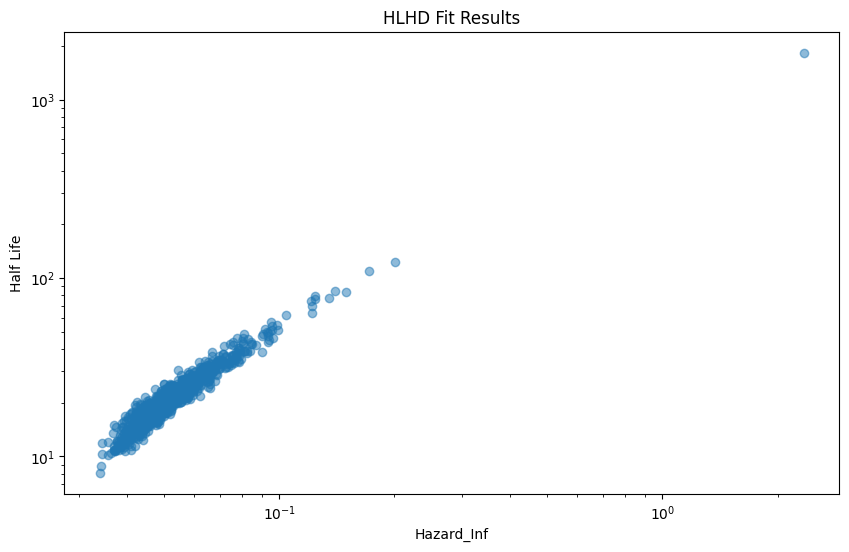

In [11]:
plot_hlh_params(fit_outs3["dtctutet"])

Here we can see the trade off in the fit between the two params, which perhaps explains why our confidence in the fire return interval can be more confident than the parameters themselves, as they can trade-off against each other particularly when the fire return interval is of similar length to the observation window. We should expect as we look at simulated environments with even larger intervals that this problem will only get worse.

### Experiment 4

A Domain with fire return intervals >2x the observation window

In [25]:
out_df4, fit_outs4 = run_hlh_simulation(
    num_pixels=500,
    time_interval=39,
    iterations=1000,
    truth=HLHD(hazard_inf=0.02, half_life=40),
    pre_window=1000,
    random_seed=42,
)

In [20]:
display(out_df4)

,name,hazard_inf_10pc,hazard_inf_mean,hazard_inf_90pc,half_life_10pc,half_life_mean,half_life_90pc,fri_10pc,fri_mean,fri_90pc,fail_count
0,truth,0.020000,0.020000,0.020000,40.000000,40.000000,40.000000,90.060716,90.060716,90.060716,0
1,dt_only,0.561814,8.677799,10.000000,63.027612,1276.841089,1826.669071,15.402361,17.932104,20.453366,15
2,dtct,0.004917,2.498121,10.000000,4.835366,6189.844282,22001.181159,67.275787,121.528512,211.701869,18
3,dtctut,3.157321,7.748087,10.000000,1849.639218,4603.652919,6155.463191,35.816899,36.734456,37.694056,64
4,dtctutet,0.014909,0.109737,0.063987,20.257664,374.311526,191.752658,83.897339,90.359616,97.325567,3
5,naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.051724,90.348089,97.500000,0


Here we can see the failure of all methods other than the proposed one to recover the fire return interval with any confidence. This makes sense because we should now expect most of the domain to have less than 1 fire on average, so we need to get as much information as possible from the subsets/pixels with 0 or 1 fire, which only the full model does precisely.

Here is a good moment to talk about the "Naive" line. I've been referring to the naive fire return interval in various discussions, but it's not really naive at all. It's a unbiased estimator of the fire return interval. It's just the # of pixels * observation window / Total pixel burn events. It's of note that at least in the case where the true distribution is of the same type as the one fitted, that the return interval confidence is the same as under this more direct measure.

In this experiment and the one prior we now get far fewer fit failures on the proposed model than the alternaitves. Perhaps this is due to the other methods failing due to the math failing (ie. there is just no stable fit when you use this imperfect methods) rather than a numerical issue? Hard to say.


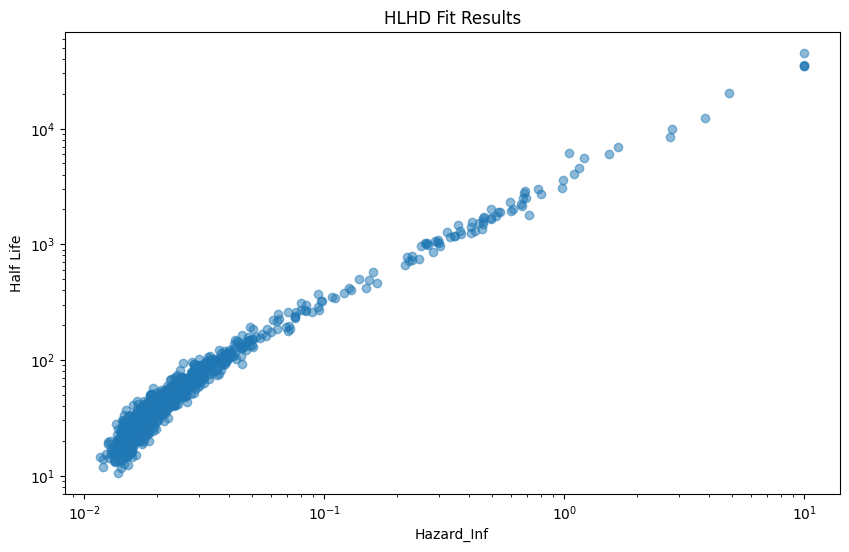

In [ ]:
plot_hlh_params(fit_outs4["dtctutet"])

As before we see the trade off between the two params, now there are more chances of seeing extreme values of both. In the most extreme case it's saying that the base line burn probability (h_inf) is that the pixels burn 10 times per year, but that the halflife for which this burn probability recovers after a burn is 10,000 years. Obviously this is a bizarre conclusion but the model doesn't know this.

I wonder if there's a different model we can construct that somehow bias's us away from these sorts of outcomes, but I also wonder if that's just part of the setup when you are trying to estimate processes that happen over timescales larger than your observation window.

### Experiment 5

How much can better can we do in the same situation as experiment 4, but in a case where we have more data? going from num_pixels 500 -> 5000

In [28]:
out_df5, fit_outs5 = run_hlh_simulation(
    num_pixels=5000,
    time_interval=39,
    iterations=1000,
    truth=HLHD(hazard_inf=0.02, half_life=40),
    pre_window=1000,
    random_seed=42,
)

In [29]:
display(out_df5)

,name,hazard_inf_10pc,hazard_inf_mean,hazard_inf_90pc,half_life_10pc,half_life_mean,half_life_90pc,fri_10pc,fri_mean,fri_90pc,fail_count
0,truth,0.020000,0.020000,0.020000,40.000000,40.000000,40.000000,90.060716,90.060716,90.060716,0
1,dt_only,10.000000,9.817019,10.000000,1276.234717,1406.562648,1553.759135,17.241354,18.039945,18.811154,11
2,dtct,0.008912,0.962487,2.954508,14.212803,2280.397194,6899.831610,72.631968,96.290490,130.721845,4
3,dtctut,3.026041,7.727798,10.000000,1792.036253,4593.493270,6023.101348,36.420983,36.745615,37.062455,78
4,dtctutet,0.017600,0.020574,0.023827,30.770808,42.068924,54.528438,87.952589,90.077489,92.223791,0
5,naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.956698,90.077798,92.242195,0


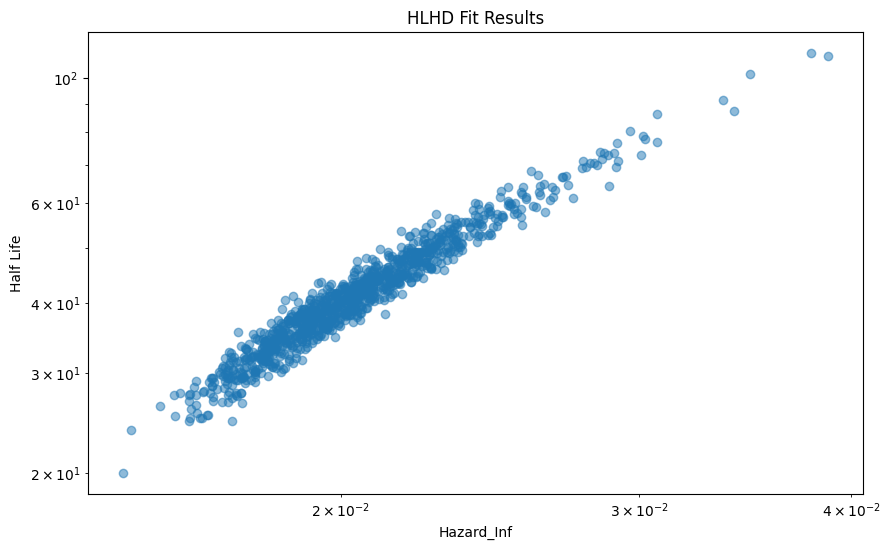

In [ ]:
plot_hlh_params(fit_outs5["dtctutet"])

Here I think we can conclude that with enough data the proposed method will be able to recover the parameters even in cases where the observation window well under the fire return interval. Dt+Ct is also getting better here, but it's unclear if it retains some bias, and it's confidence intervals for the fire return interval are far worse than the naive approach, and the full model continues to match the naive estimator almost exactly.

## Takeaways/Notes
- My understanding of how to treat the 4 different data types from a likelihood perspective is validated
- Confidence intervals for model parameters are only somewhat ok when the interval is similar to the window, and very wide once you get to >2x the window
- Adding more data can recover the information when using the full approach, but requires a large number of independent data points
- - It's unclear to me how to compare the amount of data above
- Confidence interval for the return interval remains tight even when fire return interval is well above the window
- However this isn't that valuable when it can be recovered directly with the naive measure
- The direct fire return interval calculation should be added to calculations we do (including when we get to bootstrap resampling etc.) as it's a useful and obvious measure and sanity check



In [14]:
! jupyter nbconvert --to html "mtbs_fire_analysis/analysis/statistical_tests/Sensoring_HLH_Analysis.ipynb"

[NbConvertApp] Converting notebook mtbs_fire_analysis/analysis/statistical_tests/Sensoring_HLH_Analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 532915 bytes to mtbs_fire_analysis/analysis/statistical_tests/Sensoring_HLH_Analysis.html
